# Logistic Regression with L2 regularization

The goal of this second notebook is to implement our own logistic regression classifier with L2 regularization. 

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.


In [1]:
from __future__ import division
import graphlab

## Load and process review dataset

In [2]:
products = graphlab.SFrame('amazon_baby_subset.gl/')

This non-commercial license of GraphLab Create for academic use is assigned to aguha2@jhu.edu and will expire on February 11, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1473095650.log


We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)



In [6]:
# The same feature processing (same as the previous assignments)
# ---------------------------------------------------------------
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]


def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

# Remove punctuation.
products['review_clean'] = products['review'].apply(remove_punctuation)

# Split out the words into individual columns
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

In [7]:
products

name,review,rating,sentiment,review_clean,baby
Stop Pacifier Suckingwithout tears with ...,All of my kids have criednon-stop when I tried to ...,5.0,1,All of my kids have criednonstop when I tried to ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,We wanted to getsomething to keep track ...,5.0,1,We wanted to getsomething to keep track ...,0
Nature's Lullabies SecondYear Sticker Calendar ...,My daughter had her 1stbaby over a year ago. ...,5.0,1,My daughter had her 1stbaby over a year ago She ...,1
"Lamaze Peekaboo, I LoveYou ...","One of baby's first andfavorite books, and i ...",4.0,1,One of babys first andfavorite books and it is ...,0
SoftPlay Peek-A-BooWhere's Elmo A Childr ...,Very cute interactivebook! My son loves this ...,5.0,1,Very cute interactivebook My son loves this ...,0
Our Baby Girl Memory Book,"Beautiful book, I love itto record cherished t ...",5.0,1,Beautiful book I love itto record cherished t ...,0
Hunnt&reg; FallingFlowers and Birds Kids ...,"Try this out for a springproject !Easy ,fun and ...",5.0,1,Try this out for a springproject Easy fun and ...,0
Blessed By Pope BenedictXVI Divine Mercy Full ...,very nice Divine MercyPendant of Jesus now on ...,5.0,1,very nice Divine MercyPendant of Jesus now on ...,0
Cloth Diaper PinsStainless Steel ...,We bought the pins as my6 year old Autistic son ...,4.0,1,We bought the pins as my6 year old Autistic son ...,0
Cloth Diaper PinsStainless Steel ...,It has been many yearssince we needed diaper ...,5.0,1,It has been many yearssince we needed diaper ...,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. 

In [8]:
train_data, validation_data = products.random_split(.8, seed=2)

print 'Training set   : %d data points' % len(train_data)
print 'Validation set : %d data points' % len(validation_data)

Training set   : 42361 data points
Validation set : 10711 data points


## Convert SFrame to NumPy array

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [9]:
import numpy as np

def get_numpy_data(data_sframe, features, label):
    data_sframe['intercept'] = 1
    features = ['intercept'] + features
    features_sframe = data_sframe[features]
    feature_matrix = features_sframe.to_numpy()
    label_sarray = data_sframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [10]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

## Building on logistic regression with no L2 penalty assignment

The link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 



In [11]:
'''
produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1./(1+np.exp(-score))
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. the L2 regularization is particularly useful in preventing overfitting. 

for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**:  we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. :
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [12]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    derivative = np.dot(errors,feature)
    

    # add L2 penalty term for any feature that isn't the intercept.
    if not feature_is_constant:
        derivative=derivative-(2*l2_penalty*coefficient) 
        
        
    return derivative

To verify the correctness of the gradient ascent algorithm, we use a function for computing log likelihood

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [13]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [14]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in xrange(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        derivative = np.dot(errors,feature_matrix)

        for j in xrange(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            if not is_intercept:
                coefficients[j]=coefficients[j]+(step_size*(derivative[j] - 2*l2_penalty*coefficients[j]))


            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            
            # add the step size times the derivative to the current coefficient
            #w(t+1) = w(t) + n[w'(t) - 2λw(t)]
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print 'iteration %*d: log likelihood of observed labels = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, lp)
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [15]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.43091776
iteration   1: log likelihood of observed labels = -29003.86815941
iteration   2: log likelihood of observed labels = -28835.00365894
iteration   3: log likelihood of observed labels = -28672.28434910
iteration   4: log likelihood of observed labels = -28515.26705025
iteration   5: log likelihood of observed labels = -28363.58430853
iteration   6: log likelihood of observed labels = -28216.92218213
iteration   7: log likelihood of observed labels = -28075.00565489
iteration   8: log likelihood of observed labels = -27937.58894992
iteration   9: log likelihood of observed labels = -27804.44901773
iteration  10: log likelihood of observed labels = -27675.38109285
iteration  11: log likelihood of observed labels = -27550.19560292
iteration  12: log likelihood of observed labels = -27428.71596414
iteration  13: log likelihood of observed labels = -27310.77696019
iteration  14: log likelihood of observed labels = -27196.2235

In [16]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.43461649
iteration   1: log likelihood of observed labels = -29003.88973764
iteration   2: log likelihood of observed labels = -28835.05618864
iteration   3: log likelihood of observed labels = -28672.37994230
iteration   4: log likelihood of observed labels = -28515.41696607
iteration   5: log likelihood of observed labels = -28363.79903470
iteration   6: log likelihood of observed labels = -28217.21150070
iteration   7: log likelihood of observed labels = -28075.37869773
iteration   8: log likelihood of observed labels = -27938.05424744
iteration   9: log likelihood of observed labels = -27805.01454256
iteration  10: log likelihood of observed labels = -27676.05429967
iteration  11: log likelihood of observed labels = -27550.98346506
iteration  12: log likelihood of observed labels = -27429.62500726
iteration  13: log likelihood of observed labels = -27311.81329349
iteration  14: log likelihood of observed labels = -27197.3928

In [17]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.44016458
iteration   1: log likelihood of observed labels = -29003.92210282
iteration   2: log likelihood of observed labels = -28835.13497260
iteration   3: log likelihood of observed labels = -28672.52330329
iteration   4: log likelihood of observed labels = -28515.64177978
iteration   5: log likelihood of observed labels = -28364.12101683
iteration   6: log likelihood of observed labels = -28217.64530584
iteration   7: log likelihood of observed labels = -28075.93800293
iteration   8: log likelihood of observed labels = -27938.75182542
iteration   9: log likelihood of observed labels = -27805.86232751
iteration  10: log likelihood of observed labels = -27677.06344720
iteration  11: log likelihood of observed labels = -27552.16440719
iteration  12: log likelihood of observed labels = -27430.98750321
iteration  13: log likelihood of observed labels = -27313.36647650
iteration  14: log likelihood of observed labels = -27199.1452

In [18]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration   0: log likelihood of observed labels = -29179.52338593
iteration   1: log likelihood of observed labels = -29004.40726604
iteration   2: log likelihood of observed labels = -28836.31520822
iteration   3: log likelihood of observed labels = -28674.66957594
iteration   4: log likelihood of observed labels = -28519.00535706
iteration   5: log likelihood of observed labels = -28368.93535673
iteration   6: log likelihood of observed labels = -28224.12758200
iteration   7: log likelihood of observed labels = -28084.29039634
iteration   8: log likelihood of observed labels = -27949.16265761
iteration   9: log likelihood of observed labels = -27818.50707807
iteration  10: log likelihood of observed labels = -27692.10568065
iteration  11: log likelihood of observed labels = -27569.75662359
iteration  12: log likelihood of observed labels = -27451.27192172
iteration  13: log likelihood of observed labels = -27336.47575838
iteration  14: log likelihood of observed labels = -27225.2031

In [19]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration   0: log likelihood of observed labels = -29180.35559944
iteration   1: log likelihood of observed labels = -29009.22655700
iteration   2: log likelihood of observed labels = -28847.96160521
iteration   3: log likelihood of observed labels = -28695.71046230
iteration   4: log likelihood of observed labels = -28551.76680015
iteration   5: log likelihood of observed labels = -28415.52671297
iteration   6: log likelihood of observed labels = -28286.46178947
iteration   7: log likelihood of observed labels = -28164.10136526
iteration   8: log likelihood of observed labels = -28048.02058457
iteration   9: log likelihood of observed labels = -27937.83217040
iteration  10: log likelihood of observed labels = -27833.18058392
iteration  11: log likelihood of observed labels = -27733.73773878
iteration  12: log likelihood of observed labels = -27639.19974091
iteration  13: log likelihood of observed labels = -27549.28431719
iteration  14: log likelihood of observed labels = -27463.7287

In [20]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration   0: log likelihood of observed labels = -29271.89908589
iteration   1: log likelihood of observed labels = -29271.80611200
iteration   2: log likelihood of observed labels = -29271.80370258
iteration   3: log likelihood of observed labels = -29271.80360414
iteration   4: log likelihood of observed labels = -29271.80360005
iteration   5: log likelihood of observed labels = -29271.80359988
iteration   6: log likelihood of observed labels = -29271.80359987
iteration   7: log likelihood of observed labels = -29271.80359987
iteration   8: log likelihood of observed labels = -29271.80359987
iteration   9: log likelihood of observed labels = -29271.80359987
iteration  10: log likelihood of observed labels = -29271.80359987
iteration  11: log likelihood of observed labels = -29271.80359987
iteration  12: log likelihood of observed labels = -29271.80359987
iteration  13: log likelihood of observed labels = -29271.80359987
iteration  14: log likelihood of observed labels = -29271.8035

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Below is a simple helper function that will help us create this table.

In [21]:
table = graphlab.SFrame({'word': ['(intercept)'] + important_words})
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [22]:
table

word
(intercept)
baby
one
great
love
use
would
like
easy
little


Now, let's run the function `add_coefficients_to_table` for each of the L2 penalty strengths.

In [23]:
add_coefficients_to_table(coefficients_0_penalty, 'coefficients [L2=0]')
add_coefficients_to_table(coefficients_4_penalty, 'coefficients [L2=4]')
add_coefficients_to_table(coefficients_10_penalty, 'coefficients [L2=10]')
add_coefficients_to_table(coefficients_1e2_penalty, 'coefficients [L2=1e2]')
add_coefficients_to_table(coefficients_1e3_penalty, 'coefficients [L2=1e3]')
add_coefficients_to_table(coefficients_1e5_penalty, 'coefficients [L2=1e5]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
(intercept),0.0,0.0,0.0,0.0
baby,0.0696539002285,0.0696244008539,0.0695811016142,0.0690007595543
one,0.0098600925225,0.00962757625877,0.00928481165849,0.00490009738032
great,0.791144325318,0.786525443066,0.779725276691,0.693355677971
love,1.04914218102,1.04153493709,1.0303431299,0.889311341409
use,-0.00612976772413,-0.00579712451216,-0.00530737676992,0.000873353945301
would,-0.287971302568,-0.286979657529,-0.285520233713,-0.266982683476
like,-0.0071308615295,-0.0071453711291,-0.00716712956592,-0.00747189016368
easy,0.97996087709,0.97303632434,0.962849193288,0.834483117993
little,0.519978943965,0.516988492159,0.51258663594,0.456765205396


In [24]:
table.sort('coefficients [L2=0]')

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2]
disappointed,-0.960946464546,-0.952438317042,-0.939900241495,-0.779944476985
money,-0.775725033274,-0.769602184148,-0.760591678322,-0.646863590461
return,-0.745703910435,-0.739088291592,-0.729343181098,-0.605493767581
waste,-0.622040443373,-0.616670744621,-0.608764111178,-0.508580566777
returned,-0.576085477395,-0.570862698091,-0.563163221091,-0.464655797543
broke,-0.558313695518,-0.553296208569,-0.545900516224,-0.451389916732
work,-0.532757303926,-0.528891366341,-0.523200301235,-0.451115376523
thought,-0.479247671218,-0.475332353978,-0.469565986311,-0.396324814856
idea,-0.467717361155,-0.463451947625,-0.457163609769,-0.376673609856
cheap,-0.462490283816,-0.458450486247,-0.45249727661,-0.376548771023


In [28]:
negative_words=["disappointed","money","return","waste","returned"]
positive_words=["love","loves","easy","perfect","great"]

In [29]:
table.sort('coefficients [L2=0]',ascending = False)

word,coefficients [L2=0],coefficients [L2=4],coefficients [L2=10],coefficients [L2=1e2],coefficients [L2=1e3]
love,1.04914218102,1.04153493709,1.0303431299,0.889311341409,0.418366273268
loves,1.04312236173,1.0346328893,1.02213160398,0.863528387747,0.345891725237
easy,0.97996087709,0.97303632434,0.962849193288,0.834483117993,0.401909659608
perfect,0.829001170133,0.821930568669,0.811514637801,0.678992758226,0.250630486874
great,0.791144325318,0.786525443066,0.779725276691,0.693355677971,0.376019740911
happy,0.553444227978,0.548576647077,0.541402935302,0.449813266231,0.154095743484
best,0.532806689783,0.528063114683,0.521072432582,0.431864981022,0.145594686923
little,0.519978943965,0.516988492159,0.51258663594,0.456765205396,0.251222490819
fits,0.484765961974,0.480572001471,0.474391669639,0.395548461722,0.141249237331
well,0.447457396642,0.444631046423,0.440468271189,0.387442127027,0.194928530027


Using **the coefficients trained with L2 penalty 0**, lets find the 5 most positive words (with largest positive coefficients). Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table.filter_by(column_name='word', values=positive_words)
    table_negative_words = table.filter_by(column_name='word', values=negative_words)
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in xrange(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in xrange(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. 

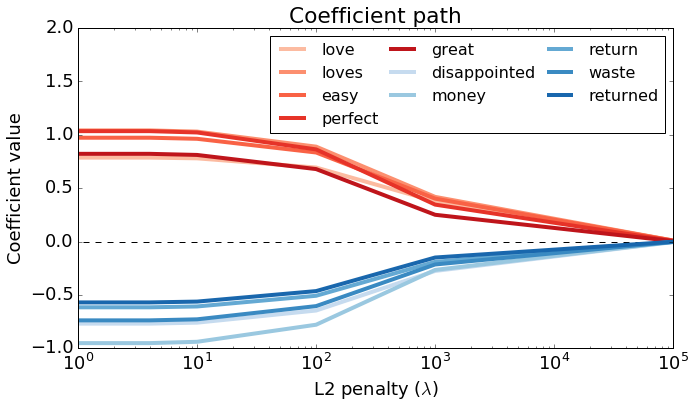

In [31]:
make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

## Measuring accuracy

Now, let us compute the accuracy of the classifier model.the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.



In [32]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients)
    apply_threshold = np.vectorize(lambda x: 1. if x > 0  else -1.)
    predictions = apply_threshold(scores)
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)    
    return accuracy

In [33]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [49]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print "L2 penalty = %g" % key
    print "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key])
    print "--------------------------------------------------------------------------------"

L2 penalty = 0
train accuracy = 0.785628290173, validation_accuracy = 0.782653347026
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785463043837, validation_accuracy = 0.782466623098
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.785463043837, validation_accuracy = 0.782559985062
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.78470763202, validation_accuracy = 0.781159555597
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.774226293053, validation_accuracy = 0.771169825413
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.744718018933, validation_accuracy = 0.744281579684
---------------------------------------------------------------------------